# **Introduction**

In this project, we are tasked with predicting the weekly sales for Walmart stores, utilizing historical sales data and various external factors. Walmart, one of the largest retail chains in the United States, seeks to predict sales more accurately in order to optimize inventory management and enhance overall business performance.

Sales performance is influenced by several variables, including economic conditions (such as the Consumer Price Index (CPI), unemployment rates, and fuel prices) and seasonal events like holidays and markdowns. Unforeseen demand fluctuations during peak times, especially around major holiday events, can lead to stock shortages and impact revenue.

This challenge is particularly relevant as Walmart holds significant promotional markdown events before key holidays such as the Super Bowl, Labor Day, Thanksgiving, and Christmas. These holidays significantly affect sales, but historical data may not fully capture the complexity of their impact. Therefore, our goal is to build regression models that predict weekly sales across 45 Walmart stores over the period from February 2010 to November 2012, considering a range of features that could explain sales fluctuations.

**Dataset Overview**

The dataset Walmart_Store_sales.csv contains sales data for 45 Walmart stores across multiple years. The dataset consists of the following columns:

*   **Store:** A unique identifier for each Walmart store.
*   **Date:** The week of sales.
*   **Weekly_Sales:** The total sales revenue for the store during the specified week.
*   **Holiday_Flag:** A binary flag indicating whether the week corresponds to a holiday (1) or non-holiday (0).
*   **Temperature:** The temperature in the region during the sales week.
*   **Fuel_Price:** The price of fuel in the region.
*   **CPI (Consumer Price Index):** The prevailing cost of goods in the region.
*   **Unemployment:** The unemployment rate in the region.


Additionally, the dataset includes information on special holiday events that may affect sales differently each year.

Our task is to analyze this dataset, engineer meaningful features, and apply regression models to predict weekly sales across different stores. Through this analysis, we will compare the performance of different models and identify the most impactful features for sales prediction.

Packages and Libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# **Data Exploration & Cleaning**

Loading the Dataset - I hosted the provided dataset on Github to remove the need of re-uploading after runtime resets without other people needing permission to access the data.

In [ ]:
url = "https://raw.githubusercontent.com/IbuChibu/Walmart_Store_Sales/refs/heads/main/Walmart_Store_sales.csv"
df = pd.read_csv(url)

# Check the first few rows
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
print(df.isnull().sum())

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


Inspecting the data shows it does not have any missing values

Inspecting for inconsistencies like:


*   duplicate records
*   incorrect data types
*   logical inconsistencies ('Holiday_Flag' should only contain 0s and 1s, 'Weekly Sales' shouldn't be negative, data should be of reasonable ranges)
*   outliers





In [ ]:
#Checking for duplicated rows
print(f"Duplicate rows: {df.duplicated().sum()}")

Duplicate rows: 0


Inspection revealed no duplicate rows in data

In [ ]:
#Inspecting datatypes of columns for incorrect data types
print(df.dtypes)

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object


All data types were as expected apart from 'Date' which is currently an object (string) but should be datetime.

In [ ]:
# Converting Date column from object to datetime format
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")

# Check Date data type after datetime conversion
print(df.dtypes)

Store                    int64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object


We can now extract useful data-based features

In [ ]:
# Extracting date-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week

# Display the first few rows to check
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9


Since Holiday_Flag is a binary flag it should only contain 0 an 1 as unique values.

In [ ]:
# Check the unique values of Holiday_Flag
print(df['Holiday_Flag'].unique())

[0 1]


Check to see if any sales are negative

In [ ]:
print(f"Negative sales count: {len(df[df['Weekly_Sales'] < 0])}")

Negative sales count: 0


See if data has reasonable ranges and other descriptive statistics

In [ ]:
print(df.describe())

             Store                 Date  Weekly_Sales  Holiday_Flag  \
count  6435.000000                 6435  6.435000e+03   6435.000000   
mean     23.000000  2011-06-17 00:00:00  1.046965e+06      0.069930   
min       1.000000  2010-02-05 00:00:00  2.099862e+05      0.000000   
25%      12.000000  2010-10-08 00:00:00  5.533501e+05      0.000000   
50%      23.000000  2011-06-17 00:00:00  9.607460e+05      0.000000   
75%      34.000000  2012-02-24 00:00:00  1.420159e+06      0.000000   
max      45.000000  2012-10-26 00:00:00  3.818686e+06      1.000000   
std      12.988182                  NaN  5.643666e+05      0.255049   

       Temperature   Fuel_Price          CPI  Unemployment         Year  \
count  6435.000000  6435.000000  6435.000000   6435.000000  6435.000000   
mean     60.663782     3.358607   171.578394      7.999151  2010.965035   
min      -2.060000     2.472000   126.064000      3.879000  2010.000000   
25%      47.460000     2.933000   131.735000      6.891000  

*   **Store:** Statistics for column is as expected
*   **Date:** Min, max and mean align with data description
*   **Weekly_Sales:** Sales figures look reasonable but vary widely - will check for outliers.
*   **Holiday_Flag:** Statistics are as expected for count, min and max. Mean of approximately 0.07 means only around 7% of weeks are holiday weeks so their impact should be analysed seperately.
*   **Temperature:** Temperature looks reasonable for US weather in degrees fahrenheit.
*   **Fuel_Price:** Seems reasonable
*   **CPI (Consumer Price Index):** Seems reasonable - CPI is expected to trend upwards, should make a timeseries plot to confirm this.
*   **Unemployment:** Looks reasonable and plausible for different stores in different economic conditions - should look at the relationship between Unemployment and Weekly_Sales.

Analysing Weekly_Sales for range distribution (and checking for possible outliers)

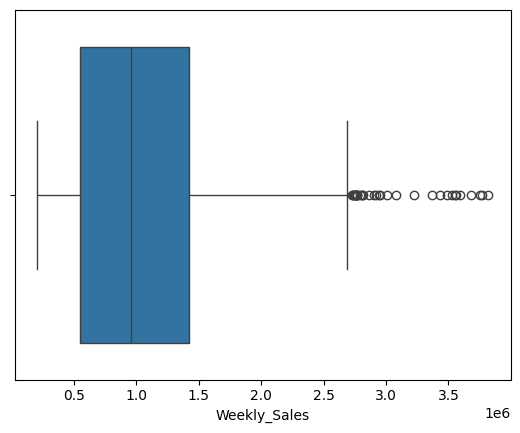

Outliers detected: 34


In [ ]:
# Making boxplot for Weekly Sales
sns.boxplot(x=df['Weekly_Sales'])
plt.show()

# Checking outliers using InterQuartileRange
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Defining threshold for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detecting and printing out of outliers
outliers = df[(df['Weekly_Sales'] < lower_bound) | (df['Weekly_Sales'] > upper_bound)]
print(f"Outliers detected: {len(outliers)}")

The boxplot and IQR analysis identify 34 potential outliers in Weekly_Sales, this could be due to major holidays or promotional events rather than data errors. Most sales fall within the interquartile range, with a few extreme values exceeding the upper bound, reflecting peak sales periods.

The detected outliers were investigated to see if they fell within holiday weeks using the Holiday_Flag column.

In [ ]:
# Outliers occuring during holiday weeks
holiday_outliers = outliers[outliers['Holiday_Flag'] == 1]

# Count of outliers that fell on holiday weeks
print(f"Outliers occurring during holiday weeks: {len(holiday_outliers)}")

# Display of the holiday outliers
holiday_outliers

Outliers occurring during holiday weeks: 9


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week
471,4,2010-11-26,2789469.45,1,48.08,2.752,126.669267,7.127,2010,11,47
523,4,2011-11-25,3004702.33,1,47.96,3.225,129.836400,5.143,2011,11,47
1329,10,2010-11-26,2939946.38,1,55.33,3.162,126.669267,9.003,2010,11,47
1381,10,2011-11-25,2950198.64,1,60.68,3.760,129.836400,7.874,2011,11,47
1758,13,2010-11-26,2766400.05,1,28.22,2.830,126.669267,7.795,2010,11,47
1810,13,2011-11-25,2864170.61,1,38.89,3.445,129.836400,6.392,2011,11,47
1901,14,2010-11-26,2921709.71,1,46.15,3.039,182.783277,8.724,2010,11,47
2759,20,2010-11-26,2811634.04,1,46.66,3.039,204.962100,7.484,2010,11,47
2811,20,2011-11-25,2906233.25,1,46.38,3.492,211.412076,7.082,2011,11,47


Of the 34 outliers, 9 were exactly during a flagged holiday week. To rule out other causes for these outliers I checked if the 25 other outliers occured one week before or after the flagged holiday weeks.

In [ ]:
outliers = outliers.copy()

# Dates of holiday weeks
holiday_weeks = df[df['Holiday_Flag'] == 1]['Date'].unique()

# Check if outliers fall within a week before or after a holiday
outliers['Date'] = pd.to_datetime(outliers['Date'])
outliers.loc[:, 'Near_Holiday'] = outliers['Date'].apply(
    lambda x: any((x - pd.Timedelta(weeks=1) <= holiday_weeks) & (x + pd.Timedelta(weeks=1) >= holiday_weeks))
)

# Count of how many outliers are near a holiday
near_holiday_outliers = outliers[outliers['Near_Holiday']]
print(f"Outliers near a holiday week: {len(near_holiday_outliers)}")

Outliers near a holiday week: 25


The analysis revealed that 25 out of 25 of the other outliers, fall within a week before or after a holiday week. This suggests these outliers are legitimate spikes in sales driven by promotional events or the impact of nearby holidays, rather than errors in the data. So the outliers will be kept in for now since they can provide insight into the data especially during high-demand periods.

**Exploratory Data Analysis with visualisations**

Looking at sales trends over time

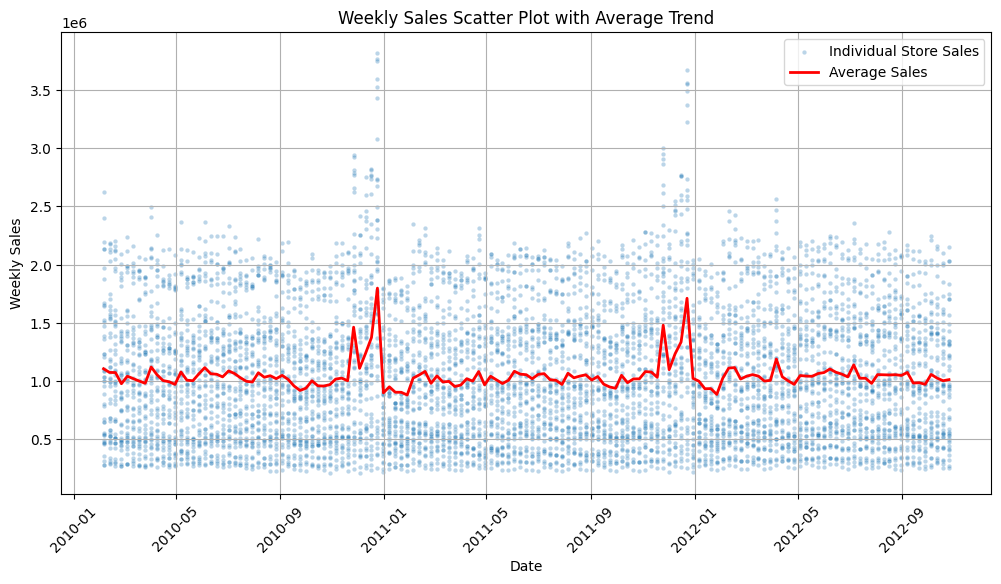

In [ ]:
plt.figure(figsize=(12, 6))

# Scatter plot for individual store sales
sns.scatterplot(x=df['Date'], y=df['Weekly_Sales'], alpha=0.3, s=10, label="Individual Store Sales")

# Calculate and plot the average sales per week
avg_sales = df.groupby('Date')['Weekly_Sales'].mean().reset_index()
sns.lineplot(x=avg_sales['Date'], y=avg_sales['Weekly_Sales'], color='red', linewidth=2, label="Average Sales")

# Labels and title
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Weekly Sales Scatter Plot with Average Trend')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()

Sales appear to stay stable over the time period with an uptick in sales around the winter holidays.

Comparison of sales during holiday vs non-holiday weeks

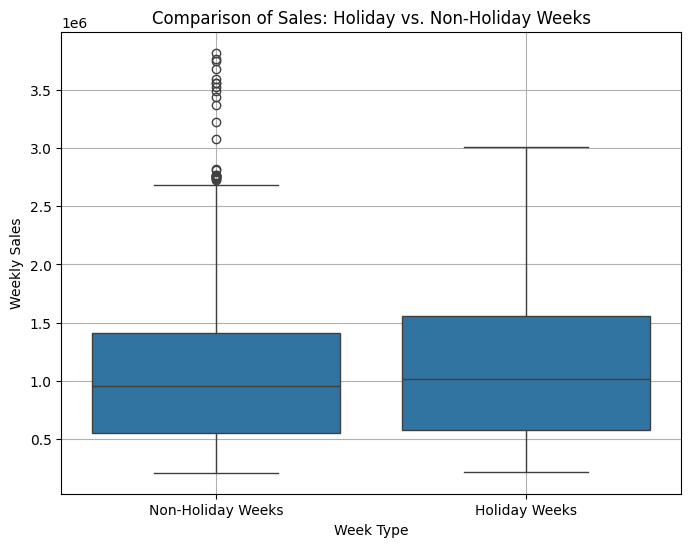

In [ ]:
#Boxplots of Non-Holiday Weeks and Holiday Weeks
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Holiday_Flag'], y=df['Weekly_Sales'])
plt.xticks([0, 1], ['Non-Holiday Weeks', 'Holiday Weeks'])
plt.xlabel('Week Type')
plt.ylabel('Weekly Sales')
plt.title('Comparison of Sales: Holiday vs. Non-Holiday Weeks')
plt.grid(True)
plt.show()

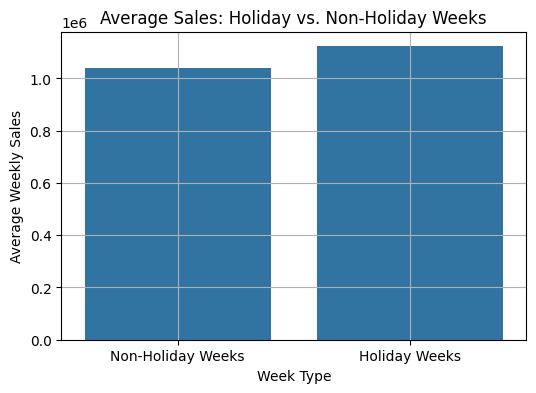

In [ ]:
# Bar-graph of average sales for Holiday weeks vs Non-Holiday weeks
sales_comparison = df.groupby('Holiday_Flag')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x=sales_comparison['Holiday_Flag'], y=sales_comparison['Weekly_Sales'])
plt.xticks([0, 1], ['Non-Holiday Weeks', 'Holiday Weeks'])
plt.xlabel('Week Type')
plt.ylabel('Average Weekly Sales')
plt.title('Average Sales: Holiday vs. Non-Holiday Weeks')
plt.grid(True)

plt.show()

The analysis above reveals sales in holiday weeks tend to be higher than non-holiday weeks.

However as we saw earlier sales of the weeks nearby holidays weeks can be higher than normal compared to non-holiday weeks so we should differentiate our plots to take them into account.

In [ ]:
# Get unique holiday dates
holiday_weeks = pd.to_datetime(df[df['Holiday_Flag'] == 1]['Date'].unique())

# Define before and after holiday weeks
week_before_holidays = holiday_weeks - pd.Timedelta(weeks=1)
week_after_holidays = holiday_weeks + pd.Timedelta(weeks=1)

# Create a new column to classify sales weeks
df['Sales_Week_Category'] = 'Non-Holiday'

df.loc[df['Date'].isin(holiday_weeks), 'Sales_Week_Category'] = 'Holiday Week'
df.loc[df['Date'].isin(week_before_holidays), 'Sales_Week_Category'] = 'Week Before Holiday'
df.loc[df['Date'].isin(week_after_holidays), 'Sales_Week_Category'] = 'Week After Holiday'

# Display count of each category
df['Sales_Week_Category'].value_counts()

,count
Sales_Week_Category,
Non-Holiday,5085
Week Before Holiday,450
Holiday Week,450
Week After Holiday,450


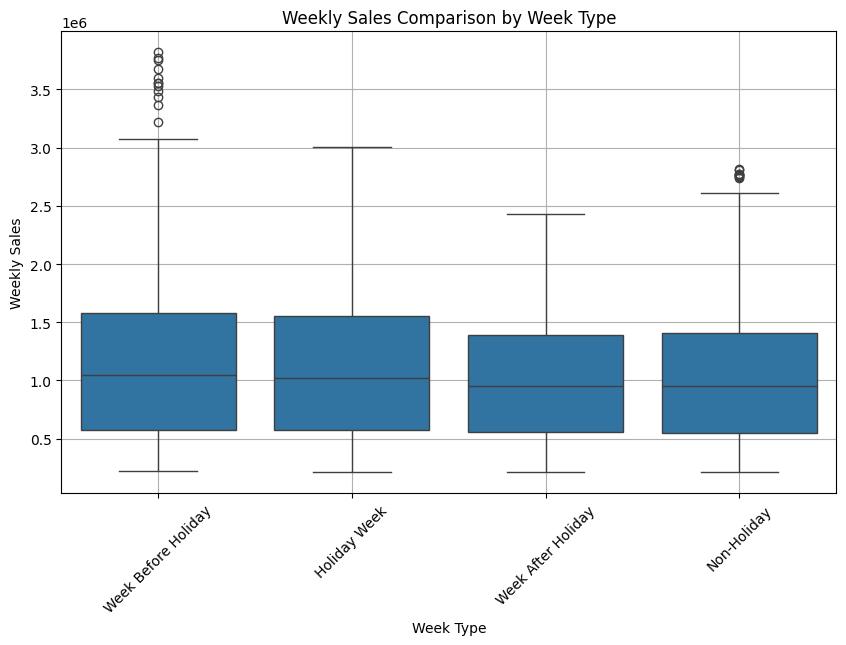

In [ ]:
#Boxplot of each type of sale week
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sales_Week_Category', y='Weekly_Sales', data=df, order=['Week Before Holiday', 'Holiday Week', 'Week After Holiday', 'Non-Holiday'])
plt.title("Weekly Sales Comparison by Week Type")
plt.xlabel("Week Type")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

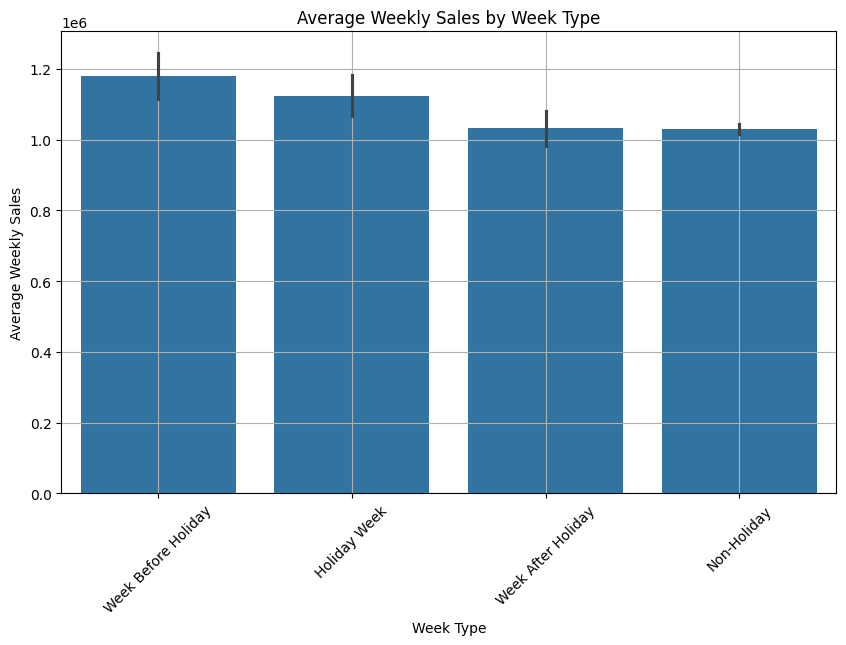

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Sales_Week_Category', y='Weekly_Sales', data=df, estimator=np.mean, order=['Week Before Holiday', 'Holiday Week', 'Week After Holiday', 'Non-Holiday'])
plt.title("Average Weekly Sales by Week Type")
plt.xlabel("Week Type")
plt.ylabel("Average Weekly Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

We can see that the weeks before holiday weeks and holiday weeks themselves have both a larger range of sales as well as higher average sales. Interestingly, the week before holiday weeks has the highest average sales, even compared to actual holiday weeks, this could be explained by customers preparing for the upcoming holiday, purchasing in advance to avoid last-minute rushes or taking advantage of pre-holiday discounts.

**Analysing the impact of fuel price, CPI, unemployment and temperature on weekly sales**

To analyse the impact of these factors on weekly sales it would be useful to calculate the correlation between them and weekly sales. A high absolute correlation would indicate these factors having a significant impact.



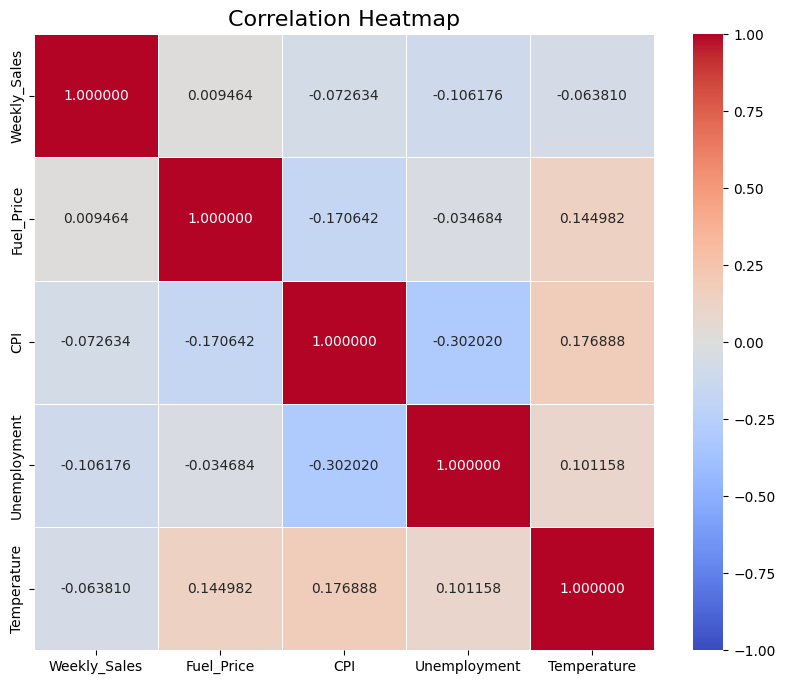

              Weekly_Sales  Fuel_Price       CPI  Unemployment  Temperature
Weekly_Sales      1.000000    0.009464 -0.072634     -0.106176    -0.063810
Fuel_Price        0.009464    1.000000 -0.170642     -0.034684     0.144982
CPI              -0.072634   -0.170642  1.000000     -0.302020     0.176888
Unemployment     -0.106176   -0.034684 -0.302020      1.000000     0.101158
Temperature      -0.063810    0.144982  0.176888      0.101158     1.000000


In [ ]:
# Select only the relevant columns for correlation calculation
selected_columns = ['Weekly_Sales', 'Fuel_Price', 'CPI', 'Unemployment', 'Temperature']

# Subset the dataframe to include only these columns
subset_df = df[selected_columns]

# Calculate the correlation
correlation = subset_df.corr()

# Set up the plot
plt.figure(figsize=(10, 8))

# Create a heatmap for the correlation matrix
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.6f', linewidths=0.5)

plt.title('Correlation Heatmap', fontsize=16)
plt.show()
print(correlation)

**Weekly_Sales and Fuel_Price:**

Correlation: 0.009464

Interpretation: The correlation between weekly sales and fuel price is extremely low (close to 0), indicating that there is almost no relationship between the two variables. This suggests that fuel price does not significantly affect weekly sales in this dataset.

**Weekly_Sales and CPI (Consumer Price Index):**

Correlation: -0.072634

Interpretation: There is a very weak negative correlation between weekly sales and CPI. A negative correlation means that as the CPI increases, weekly sales tend to decrease, but the correlation is weak. This suggests that CPI, which reflects the overall price level of goods and services, doesn't have a strong or direct impact on weekly sales.

**Weekly_Sales and Unemployment:**

Correlation: -0.106176

Interpretation: There is a weak negative correlation between weekly sales and unemployment. As unemployment increases, weekly sales tend to decrease slightly. However, the weak strength of this correlation suggests that unemployment (or employment) is not a strong driver of sales.

**Weekly_Sales and Temperature:**

Correlation: -0.063810

Interpretation: There is a very weak negative correlation between weekly sales and temperature. This suggests that temperature has a very minimal impact on weekly sales, with slightly lower sales as temperature increases, but the effect is weak.

NOTE: The features (Fuel_Price, CPI, Unemployment, Temperature) show weak correlations with each other, suggesting they are largely independent. This independence is beneficial for models like linear regression, which assume no multicollinearity helping improve the stability and interpretability of the model.

The above heatmap used Pearson correlation, which measures the linear relationship between two variables. Non-linear relationships (e.g., quadratic or exponential) won’t be detected. To check for non-linear relationships we can use other methods like Spearman's rank correlation or mutual information, but we can also first visually check for relationships with scatter plots of the features against Weekly_Sales.

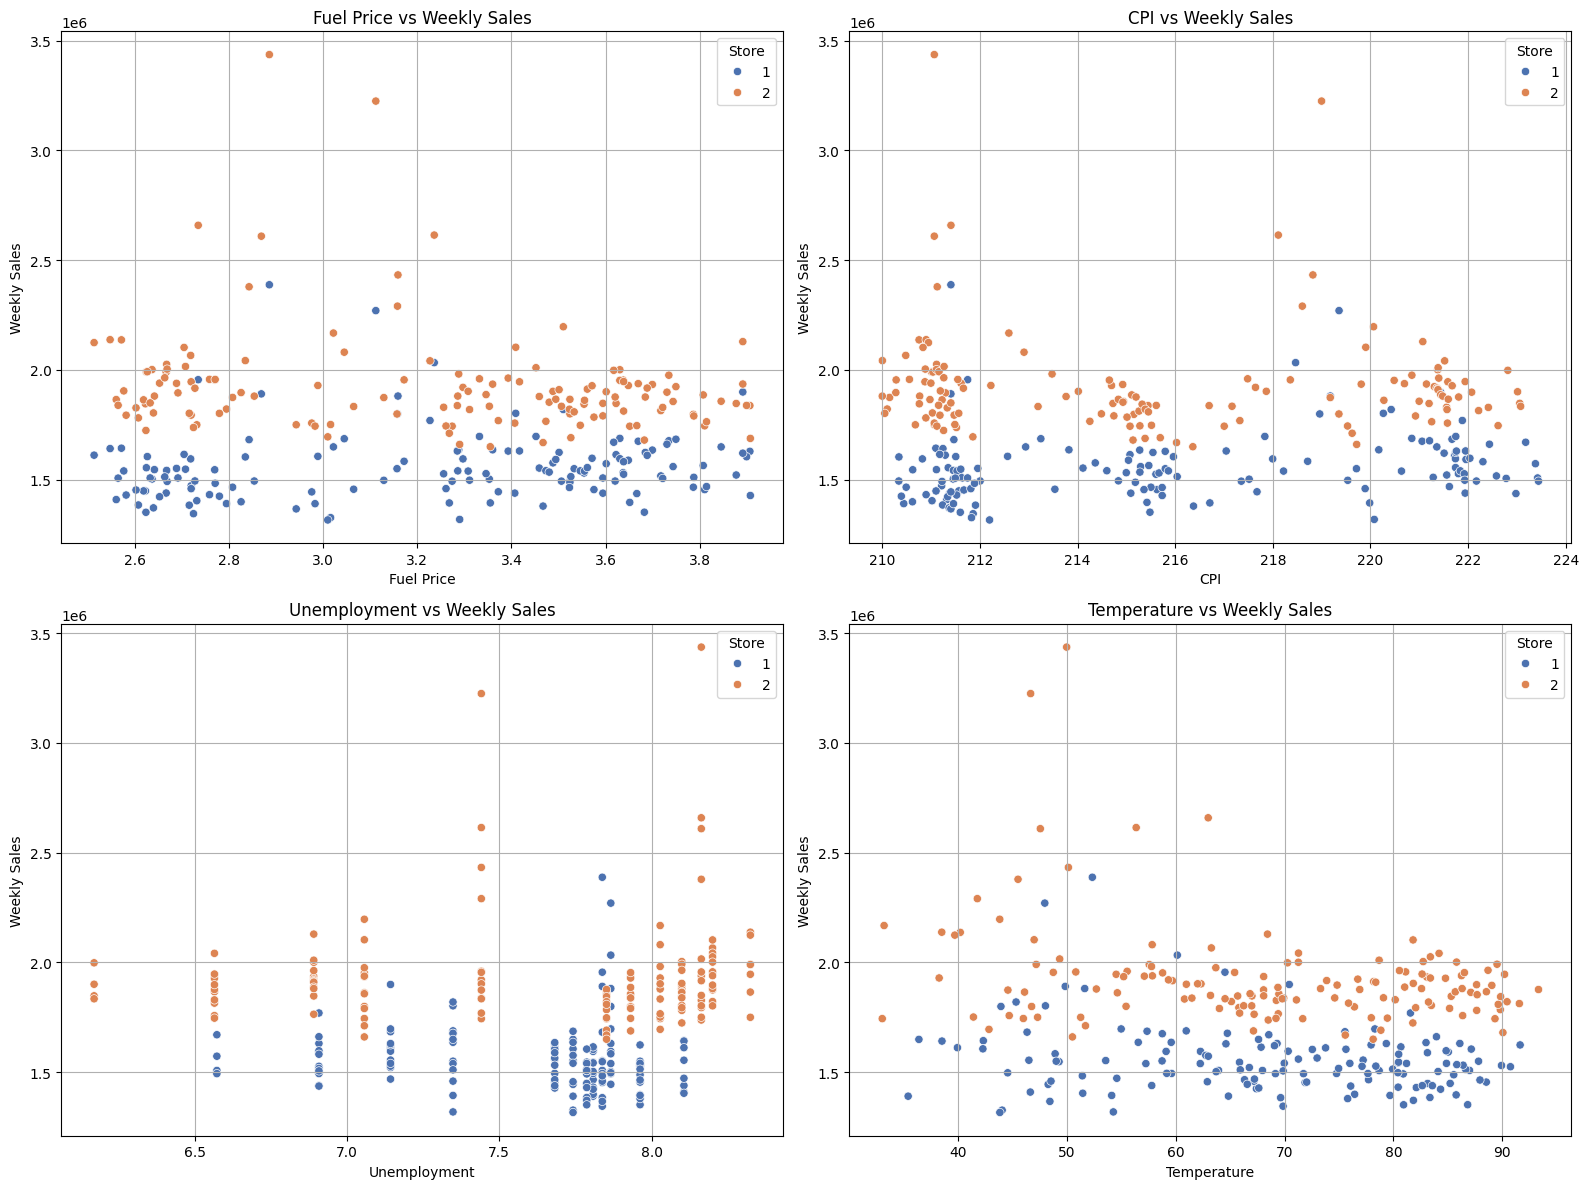

In [ ]:
# List of store numbers for plotting
store_numbers = [1, 2]

# Filter data for the specified stores
store_data = df[df['Store'].isin(store_numbers)]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot Fuel Price vs Weekly Sales
sns.scatterplot(x='Fuel_Price', y='Weekly_Sales', data=store_data, hue='Store', ax=axes[0, 0], palette='deep')
axes[0, 0].set_title('Fuel Price vs Weekly Sales')
axes[0, 0].set_xlabel('Fuel Price')
axes[0, 0].set_ylabel('Weekly Sales')
axes[0, 0].grid(True)

# Plot CPI vs Weekly Sales
sns.scatterplot(x='CPI', y='Weekly_Sales', data=store_data, hue='Store', ax=axes[0, 1], palette='deep')
axes[0, 1].set_title('CPI vs Weekly Sales')
axes[0, 1].set_xlabel('CPI')
axes[0, 1].set_ylabel('Weekly Sales')
axes[0, 1].grid(True)

# Plot Unemployment vs Weekly Sales
sns.scatterplot(x='Unemployment', y='Weekly_Sales', data=store_data, hue='Store', ax=axes[1, 0], palette='deep')
axes[1, 0].set_title('Unemployment vs Weekly Sales')
axes[1, 0].set_xlabel('Unemployment')
axes[1, 0].set_ylabel('Weekly Sales')
axes[1, 0].grid(True)

# Plot Temperature vs Weekly Sales
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=store_data, hue='Store', ax=axes[1, 1], palette='deep')
axes[1, 1].set_title('Temperature vs Weekly Sales')
axes[1, 1].set_xlabel('Temperature')
axes[1, 1].set_ylabel('Weekly Sales')
axes[1, 1].grid(True)

plt.tight_layout()

plt.show()

Analysing the scatter plots of the features for different stores match with what is expected from the correlation matrix - that is they are not strongly linearly correlated with Weekly_Sales. Additionally nonlinear relationships are not immediately obvious. However lets use Spearman's rank correlation and mutual information to search for non-linear relationships in an objective way.

Spearman's rank correlation calculates the correlation based on the rank of the values instead of the actual values themselves, making it more appropriate for monotonic relationships (whether linear or not). This means that it can capture relationships that are not strictly linear but still show a consistent increase or decrease.

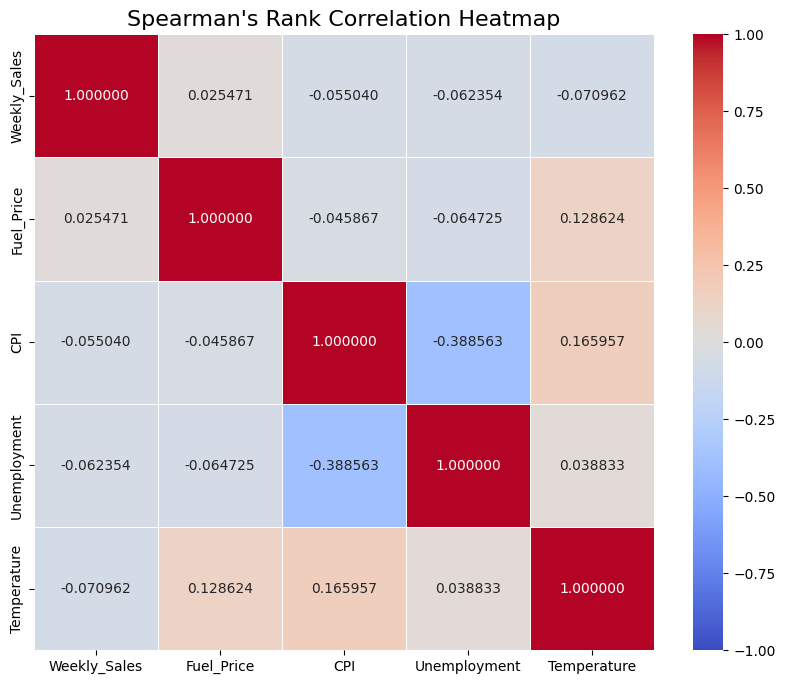

              Weekly_Sales  Fuel_Price       CPI  Unemployment  Temperature
Weekly_Sales      1.000000    0.025471 -0.055040     -0.062354    -0.070962
Fuel_Price        0.025471    1.000000 -0.045867     -0.064725     0.128624
CPI              -0.055040   -0.045867  1.000000     -0.388563     0.165957
Unemployment     -0.062354   -0.064725 -0.388563      1.000000     0.038833
Temperature      -0.070962    0.128624  0.165957      0.038833     1.000000


In [ ]:
# Calculate the Spearman's rank correlation
spearman_correlation = subset_df.corr(method='spearman')

# Set up the plot
plt.figure(figsize=(10, 8))

# Create a heatmap for the Spearman's rank correlation matrix
sns.heatmap(spearman_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.6f', linewidths=0.5)

plt.title('Spearman\'s Rank Correlation Heatmap', fontsize=16)
plt.show()
print(spearman_correlation)

The Spearman's rank correlation values are quite small, suggesting that none of these features (Fuel Price, CPI, Unemployment, Temperature) have a strong monotonic relationship with Weekly Sales.

Since their might be other non-linear non-monotonic relationship, we will also use mutual information method. Mutual Information goes beyond Pearson and Spearman by capturing all types of relationships, including non-linear and non-monotonic ones. While Pearson measures linear relationships and Spearman identifies monotonic trends, Mutual Information can detect more complex patterns, revealing hidden dependencies between variables that other two methods might miss.

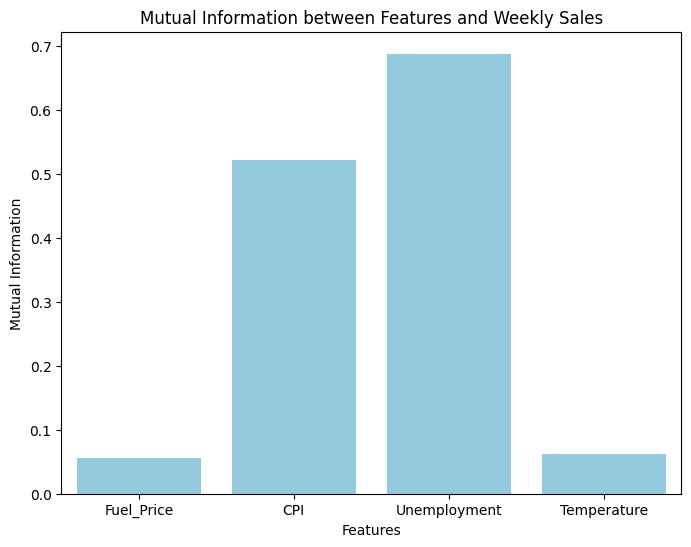

              Mutual Information
Fuel_Price              0.055589
CPI                     0.521203
Unemployment            0.688431
Temperature             0.061437


In [ ]:
# Separate the target variable (Weekly_Sales) from the features in the subset
X = subset_df.drop(columns='Weekly_Sales')
y = subset_df['Weekly_Sales']

# Calculate mutual information
mutual_info = mutual_info_regression(X, y)

# Convert to DataFrame for easier visualization
mutual_info_df = pd.DataFrame(mutual_info, index=X.columns, columns=['Mutual Information'])

# Plotting the mutual information
plt.figure(figsize=(8, 6))
sns.barplot(x=mutual_info_df.index, y=mutual_info_df['Mutual Information'], color='skyblue')
plt.title('Mutual Information between Features and Weekly Sales')
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.show()

# Print the mutual information values
print(mutual_info_df)

The mutual information values (ranging from 0 to 1) indicate the strength of the relationship between each feature and Weekly_Sales:

**Fuel_Price (0.055367)**: Very weak relationship, suggesting fuel price has minimal impact on sales.

**CPI (0.521256)**: Moderate relationship, indicating CPI plays a notable role in sales fluctuations.

**Unemployment (0.688158)**: Strong relationship, suggesting unemployment significantly impacts sales.

**Temperature (0.061393)**: Very weak relationship, indicating temperature has little effect on sales.

Conclusion: Unemployment and CPI show the strongest relationships with Weekly_Sales, making them more useful for predictive models, while Fuel_Price and Temperature have minimal impact.

### **Conclusion:**
Through this exploratory data analysis (EDA), we have uncovered several insights about the relationship between Weekly Sales and various factors:



**Sales Trends Over Time**: We observed distinct sales trends, with noticeable
seasonal fluctuations and spikes, especially during holiday periods. This indicates that sales tend to follow certain cyclical patterns, and holiday periods significantly contribute to higher sales.

**Holiday vs. Non-Holiday Sales**: Our analysis highlighted a clear difference between sales during holiday and non-holiday weeks. Sales during holidays were consistently higher, reinforcing the importance of these periods in driving up sales figures.

**Impact of External Factors**:
*   Fuel Price: There was a very weak correlation between fuel price and Weekly Sales, suggesting that fuel price changes do not significantly impact sales in this dataset.
*   CPI (Consumer Price Index): CPI showed moderate mutual information with sales, indicating that broader economic conditions reflected by CPI may have a moderate impact on sales trends.
*   Unemployment: Unemployment demonstrated the strongest relationship with sales, suggesting that higher unemployment rates might lead to lower sales, potentially due to shifts in consumer behavior during economic downturns.
*   Temperature: Temperature exhibited a very weak relationship with sales, implying that weather variations have minimal impact on Weekly Sales.

Overall, this analysis suggests that unemployment and CPI are more influential factors for predicting Weekly Sales, while fuel price and temperature appear to have a negligible or weak effect. These insights can help in focusing predictive models on the most relevant features to enhance sales forecasting accuracy.

# **Feature Engineering**


The data after the transformations so far looks like this

In [ ]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Sales_Week_Category
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,Week Before Holiday
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6,Holiday Week
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7,Week After Holiday
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8,Non-Holiday
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9,Non-Holiday


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Store                6435 non-null   int64         
 1   Date                 6435 non-null   datetime64[ns]
 2   Weekly_Sales         6435 non-null   float64       
 3   Holiday_Flag         6435 non-null   int64         
 4   Temperature          6435 non-null   float64       
 5   Fuel_Price           6435 non-null   float64       
 6   CPI                  6435 non-null   float64       
 7   Unemployment         6435 non-null   float64       
 8   Year                 6435 non-null   int32         
 9   Month                6435 non-null   int32         
 10  Week                 6435 non-null   UInt32        
 11  Sales_Week_Category  6435 non-null   object        
dtypes: UInt32(1), datetime64[ns](1), float64(5), int32(2), int64(2), object(1)
memory usage: 5

Since the aim is to predict weekly sales we need to create a column for next week's sales which will act as our target variable.

Some of the suggested lag features were also added like for the previous weeks using shift function, and rolling averages of the Weekly_Sales were also added.

Since there was a strong relationship between sales and holiday weeks particulary for the week before a holiday week, newly created 'Sales_Week_Category' was one-hot encoded.

In [ ]:
# Create target variable (next week's sales)
df["Future_Weekly_Sales_t1"] = df.groupby("Store")["Weekly_Sales"].shift(-1)

# Lag features (previous sales)
df["Lag_1"] = df.groupby("Store")["Weekly_Sales"].shift(1)
df["Lag_2"] = df.groupby("Store")["Weekly_Sales"].shift(2)
df["Lag_3"] = df.groupby("Store")["Weekly_Sales"].shift(3)
df["Lag_4"] = df.groupby("Store")["Weekly_Sales"].shift(4)

# Moving Averages
df["MA_4"] = df.groupby("Store")["Weekly_Sales"].rolling(4).mean().reset_index(0, drop=True)
df["MA_8"] = df.groupby("Store")["Weekly_Sales"].rolling(8).mean().reset_index(0, drop=True)

# One-hot encode categorical features
df = pd.get_dummies(df, columns=["Sales_Week_Category"], drop_first=True)

# Drop rows with NaN from shifting
df.dropna(inplace=True)

# View the dataframe after feature engineering
print(df.head())

    Store       Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
7       1 2010-03-26    1404429.92             0        51.45       2.732   
8       1 2010-04-02    1594968.28             0        62.27       2.719   
9       1 2010-04-09    1545418.53             0        65.86       2.770   
10      1 2010-04-16    1466058.28             0        66.32       2.808   
11      1 2010-04-23    1391256.12             0        64.84       2.795   

           CPI  Unemployment  Year  Month  ...  Future_Weekly_Sales_t1  \
7   211.018042         8.106  2010      3  ...              1594968.28   
8   210.820450         7.808  2010      4  ...              1545418.53   
9   210.622857         7.808  2010      4  ...              1466058.28   
10  210.488700         7.808  2010      4  ...              1391256.12   
11  210.439123         7.808  2010      4  ...              1425100.71   

         Lag_1       Lag_2       Lag_3       Lag_4          MA_4  \
7   1472515.79  1439541.

# **Model Selection & Training**

Relevant features were selected and then data split into training and testing sets for later tests of generalisability of the model.

The indices of the dataframes were saved for later use when predictions need to be appended to the data for analysis purposes.

Scikit-learn Pipeline was used to apply scaling and allow for editing of feature engineering while preventing data leakage.

In [ ]:
# Define features and target
features = ["Weekly_Sales", "Lag_1", "Lag_2", "Lag_3", "Lag_4", "MA_4", "MA_8",
            "Temperature", "Fuel_Price", "CPI", "Unemployment", "Holiday_Flag", "Month"]
X = df[features]
y = df["Future_Weekly_Sales_t1"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], y, test_size=0.2, shuffle=False)

# Store the indices for later use
train_index = X_train.index
test_index = X_test.index

# Define the preprocessing pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler())
])

# Fit and transform the training data and transform the test data
X_train_scaled = pipeline.fit_transform(X_train)
X_test_scaled = pipeline.transform(X_test)

Initiated and trained base models for Linear Regression, Random Forest and XGBRegressor.

I used cross-validation to get a more reliable estimate of the model’s performance by training it on different data subsets. This helps reduce overfitting and ensures better generalization to new, unseen data.

In [ ]:
# Define the models to evaluate
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Evaluate models using cross-validation and RMSE
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="neg_root_mean_squared_error")
    print(f"{name}: RMSE = {-scores.mean():.4f}")

Linear Regression: RMSE = 146949.5331
Random Forest: RMSE = 113169.6464
XGBoost: RMSE = 106879.0457


XGBoost had the best performance out of the base models so I chose it for hyperparameter tuning. Random Regressor would also have been a good model for hyperparameter tuning.

Due to the large search space for the hyperparameters - I used RandomizedSearchCV as opposed to GridSearchCV for faster optimisation.

In [ ]:
param_grid = {
    "n_estimators": [50, 100, 200, 300, 500],
    "max_depth": [3, 5, 7, 9, 11],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5]
}
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_distributions=param_grid,
    n_iter=100,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train_scaled, y_train)

print("Best Parameters:", random_search.best_params_)

Best Parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}


# **Model Evaluation & Justification**

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)

# Calculate evaluation metrics
print("R² Score:", r2_score(y_test, y_pred))

# Calculate RMSE (Root Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

R² Score: 0.9679569640494183
RMSE: 70356.33586526284
MAE: 45688.38854269547


In [ ]:
# Create a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({
    'Store': df.loc[test_index, 'Store'],
    'Date': df.loc[test_index, 'Date'],
    'Actual Future Weekly Sales': y_test,
    'Predicted Future Weekly Sales': y_pred
})

# Display the comparison dataframe
print(comparison_df.head())

      Store       Date  Actual Future Weekly Sales  \
5155     37 2010-03-26                   540189.70   
5156     37 2010-04-02                   513327.55   
5157     37 2010-04-09                   524544.83   
5158     37 2010-04-16                   527019.78   
5159     37 2010-04-23                   517850.83   

      Predicted Future Weekly Sales  
5155                   540674.68750  
5156                   543383.43750  
5157                   519305.09375  
5158                   520009.87500  
5159                   518877.84375  


Scatter plot of predicted vs actual - the better the prediction the closer the points will cluster around the y=x line.

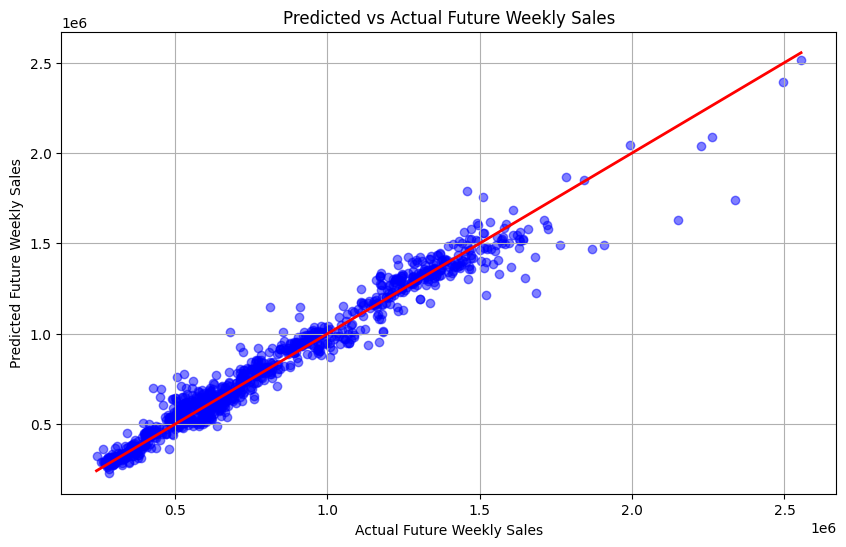

In [ ]:
# Plot Predicted vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('Predicted vs Actual Future Weekly Sales')
plt.xlabel('Actual Future Weekly Sales')
plt.ylabel('Predicted Future Weekly Sales')
plt.grid(True)
plt.show()

From the above plot we can see that the model is generally quite accurate - however there are some points where the absolute error is relatively high in comparison, which will have an effect on aggregated accuracy metrics like MAE or RMSE.

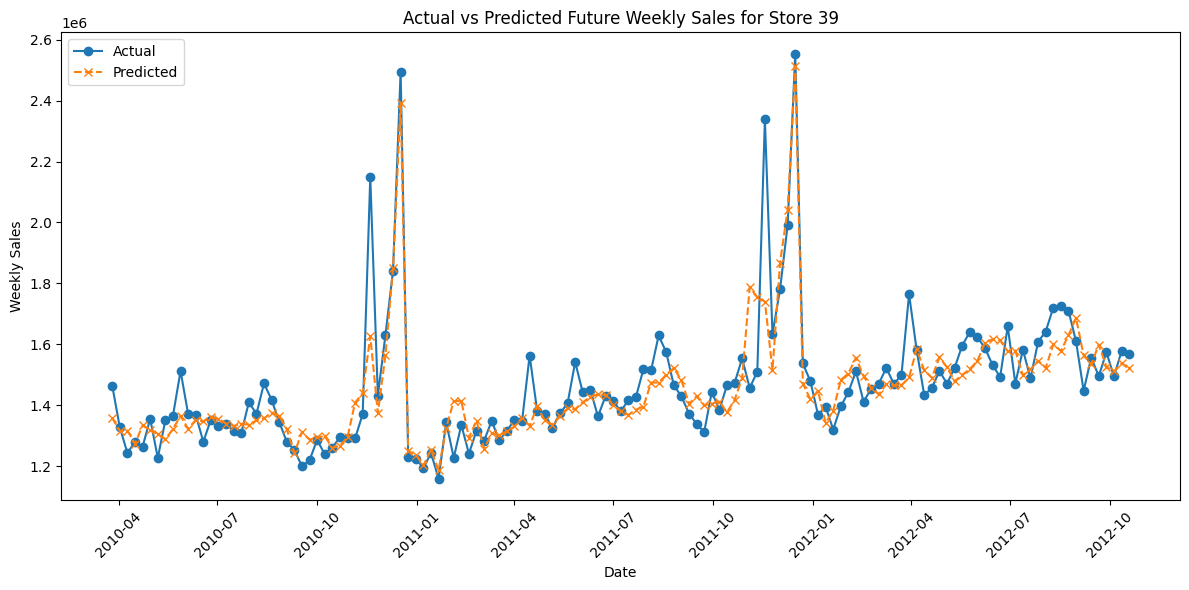

In [ ]:
# Set the store number for plotting
store_number = 39

# Filter data for the selected store
store_data = comparison_df[comparison_df['Store'] == store_number]

# Create the plot for the selected store
plt.figure(figsize=(12, 6))

# Plot actual and predicted sales for the chosen store
plt.plot(store_data['Date'], store_data['Actual Future Weekly Sales'], label="Actual", linestyle='-', marker='o')
plt.plot(store_data['Date'], store_data['Predicted Future Weekly Sales'], label="Predicted", linestyle='--', marker='x')

# Plot title and labels
plt.title(f"Actual vs Predicted Future Weekly Sales for Store {store_number}")
plt.xlabel("Date")
plt.ylabel("Weekly Sales")
plt.legend(loc='upper left')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# **Business Insights & Recommendations**

## **Model Interpretation in a Business Context**

The predictive model demonstrates strong performance, with an R² score of 0.968, indicating that it captures 96.8% of the variance in weekly sales. However, the RMSE of 70,356 suggests that while predictions are generally accurate, there is room for improvement in reducing absolute errors. The model effectively leverages historical sales, economic indicators, and seasonal patterns to predict future sales, making it a valuable tool for inventory planning and financial forecasting, however with the caveat that absolute errors can be high in cases so the model should currrently be used with caution and improved further in the future to make it more reliable.

## **How Economic Conditions Affect Walmart’s Sales**

Economic indicators such as CPI (inflation), unemployment, and fuel prices influence consumer spending behaviors, which in turn impact Walmart’s weekly sales. By analyzing both Pearson’s correlation and Mutual Information (MI), we can better understand these relationships.

1. **Unemployment: Strongest Economic Predictor**

Mutual Information Score: 0.689 (highest among economic factors)

Pearson’s Correlation: -0.106 (weak negative correlation)

🔹 Interpretation:

The negative correlation suggests that higher unemployment leads to lower weekly sales, as fewer consumers have disposable income.
However, Walmart’s low-cost business model may mitigate this effect, as price-sensitive consumers may shift from competitors to Walmart during economic downturns.

The high MI score indicates a strong non-linear relationship, meaning unemployment may affect sales in a more complex way than a simple linear decrease.

📌 Business Implication:

Walmart should adjust inventory and pricing strategies in response to unemployment trends.
Increased unemployment might require aggressive promotions on essential goods to retain price-sensitive customers.
Expansion of discount programs and store-brand products can help maintain sales.

2. **CPI (Inflation): Moderate Influence on Sales**

Mutual Information Score: 0.521

Pearson’s Correlation: -0.073

🔹 Interpretation:

A weak negative correlation suggests that rising inflation slightly reduces overall sales.
As prices increase, discretionary spending may decline while essential goods remain stable.
The relatively high MI score suggests that inflation’s impact is more complex and not purely linear.

📌 Business Implication:

Walmart should monitor CPI trends and dynamically adjust pricing strategies.
Implement markdowns and bundle promotions on non-essential goods to maintain sales volume during periods of high inflation.
Strengthen supply chain efficiency to minimize cost increases passed to customers.

3. **Fuel Prices: Minimal Direct Impact**

Mutual Information Score: 0.056 (lowest)

Pearson’s Correlation: 0.009 (near zero)

🔹 Interpretation:

Unlike CPI and unemployment, fuel prices show almost no direct correlation with weekly sales.
This suggests that consumers prioritize Walmart shopping regardless of fuel price fluctuations.
However, high fuel prices may indirectly impact logistics costs, which could lead to price adjustments on goods.

📌 Business Implication:

Walmart should focus on supply chain optimization rather than adjusting consumer prices based on fuel costs.
During periods of high fuel prices, Walmart can increase online sales incentives (e.g., free delivery, curbside pickup) to accommodate consumers reducing trips to physical stores.


## **Adjusting Walmart's Markdown Strategies**

Based on the exploratory data analysis (EDA) and the predictive model, Walmart can refine its markdown strategies by leveraging economic indicators, historical trends, and machine learning insights.

1. Data-Driven Markdown Timing Based on Seasonality

The model highlights strong seasonal trends, particularly spikes in sales during November (Thanksgiving) and December (Christmas). This suggests that markdowns should be strategically applied before these high-sales periods to drive early purchases and avoid stockouts. The moving average features (MA_4, MA_8) and lag features in the model capture these trends, reinforcing the importance of anticipating demand rather than reacting to it.

2. Economic Conditions and Targeted Discounts

EDA revealed that CPI and unemployment have the highest mutual information scores with sales (0.521 and 0.689, respectively), suggesting a significant impact.

CPI (Inflation): As CPI increases, consumer purchasing power decreases. The negative Pearson correlation (-0.07) supports this, indicating that higher inflation tends to reduce sales. Walmart should consider markdowns on essential products during periods of high inflation to maintain customer engagement.

Unemployment: A strong negative Pearson correlation (-0.11) suggests that higher unemployment leads to lower sales. Walmart can mitigate this by offering price reductions on essential goods when unemployment rates rise, ensuring affordability for price-sensitive consumers.

Fuel Prices: Mutual information (0.055) and Pearson correlation (0.009) indicate a weaker relationship, but rising fuel costs can still impact supply chain expenses. Walmart should monitor fuel price trends and adjust markdowns accordingly, particularly for products with high transportation costs.

3. Machine Learning for Optimized Markdown Decisions

The XGBoost model, with an R² score of 0.968, shows high predictive power, suggesting that markdown decisions can be dynamically optimized. Features such as lagged sales, moving averages, and economic indicators provide a reliable basis for anticipating demand fluctuations. By integrating real-time predictions, Walmart can apply targeted markdowns only when sales are expected to decline, avoiding unnecessary revenue loss.

4. Inventory Clearance Optimization

By analyzing past markdown effectiveness and future sales trends, Walmart can refine clearance markdown timing. Instead of reducing prices when products are already stagnant, the model allows for markdowns just before demand begins to drop, maximizing revenue while preventing excess inventory buildup.

## **Improving Model Performance**

Despite achieving a strong R² score of 0.968, several enhancements could further refine the model’s accuracy and robustness:

*   Feature Engineering Enhancements - can experiment more with feature engineering to improve model performance
*   Further optimize the XGBoost hyperparameters by using Bayesian Optimization instead of RandomizedSearchCV, which would allow for a more efficient search over a large parameter space.
*   Experiment with alternative models, such as LightGBM (faster training with large datasets) or LSTM (Long Short-Term Memory Networks) to capture sequential dependencies in the time-series data.
*   Integrate real-time economic data (fuel prices, unemployment rates, CPI updates) to improve predictive adaptability.
*   Include forecasted weather data, as future weather conditions may impact in-store traffic.
*   Increase granularity of data from weekly to daily and train model on higher granularity data for more precise forcasting.

## **Deployment Strategy**

To operationalise the model, Walmart should establish a scalable and automated workflow.


*   Use Apache Airflow or AWS Step Functions to schedule daily or weekly data ingestion from Walmart’s databases and external sources (economic indicators, weather APIs).
*   Automate feature engineering and preprocessing using tools like Dask or Spark for handling large-scale data efficiently.
Model Deployment via API
*   Deploy the trained model as a REST API using FastAPI or Flask to enable real-time predictions.
*   Containerise the API with Docker and deploy on AWS Lambda for example.
*   Implement MLflow or Weights & Biases for model tracking, version control, and performance monitoring.
*   Set up an A/B testing framework to compare the current model’s predictions against real sales data, ensuring continuous improvement.
*   Schedule periodic retraining (weekly/monthly) using the latest data to adapt to changing consumer behavior and market conditions.


# **OPTIONAL : Feature Importance**

This section extracts and visualizes feature importance from the trained XGBoost model. The importance is measured using the "gain" metric, which reflects how much each feature contributes to reducing the model’s prediction error. By mapping feature indices to actual column names, we can interpret which factors influence sales the most. This helps in understanding key drivers and refining future forecasting strategies.

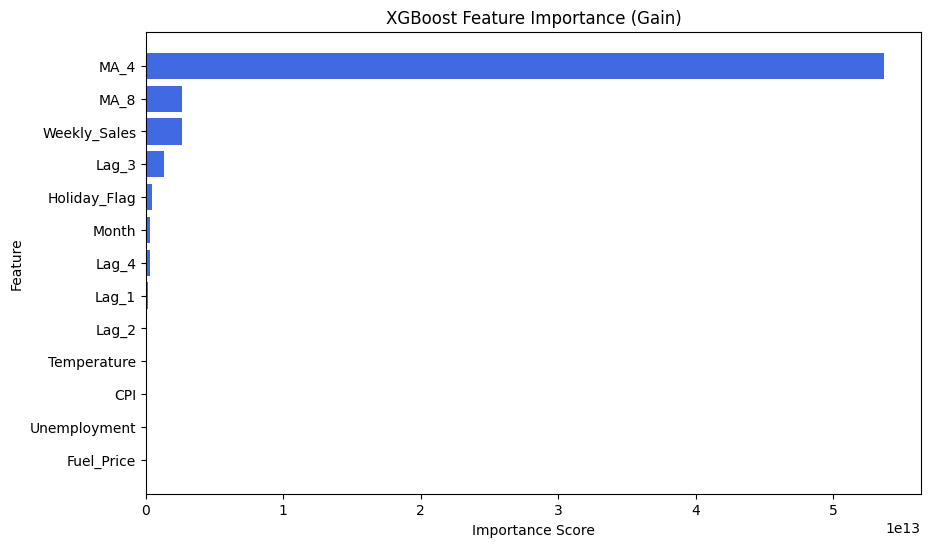

         Feature    Importance
5           MA_4  5.370989e+13
6           MA_8  2.610848e+12
0   Weekly_Sales  2.594672e+12
3          Lag_3  1.321592e+12
11  Holiday_Flag  4.103052e+11
12         Month  3.172760e+11
4          Lag_4  2.653376e+11
1          Lag_1  1.457741e+11
2          Lag_2  1.137820e+11
7    Temperature  6.444934e+10
9            CPI  6.212055e+10
10  Unemployment  6.073081e+10
8     Fuel_Price  5.232465e+10


In [ ]:
# Get feature names from the original DataFrame before scaling
feature_names = X_train.columns

# Extract feature importance with actual feature names
feature_importance = best_model.get_booster().get_score(importance_type="gain")

# Map feature indices to actual column names
feature_mapping = {f"f{i}": col for i, col in enumerate(feature_names)}
importance_df = pd.DataFrame(
    {"Feature": [feature_mapping[f] for f in feature_importance.keys()],
     "Importance": list(feature_importance.values())}
)

# Sort by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"], color="royalblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance (Gain)")
plt.gca().invert_yaxis()
plt.show()

print(importance_df)

The output table ranks features by their importance in predicting weekly sales. The most influential features are moving averages (MA_4, MA_8), which capture recent sales trends and help smooth fluctuations. The current weekly sales (Weekly_Sales) also holds high importance, likely due to the model leveraging recent values for forecasting. Lag features (Lag_1, Lag_2, Lag_3, etc.) are also relevant, indicating that past sales significantly influence future sales.

Among economic variables, CPI, Unemployment, and Fuel Price have lower importance scores, suggesting they play a relatively minor role in driving weekly sales. However, Holiday_Flag and Month contribute noticeably, confirming that seasonal patterns and holidays significantly impact sales.

This analysis confirms that short-term historical sales trends (moving averages and lags) are the strongest predictors, while economic factors provide some additional context but are less critical.